<a href="https://colab.research.google.com/github/11SST11/Lensing-out-movies/blob/main/MovieRec_MovieLens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1: Import Dependencies


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Step 2: Load Data

In [2]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')

In [3]:
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


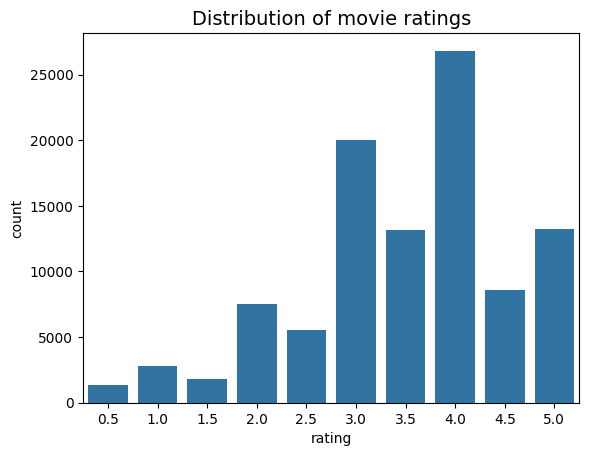

In [9]:
sns.countplot( x= 'rating', data= ratings      )
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [10]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

Mean global rating: 3.5.


In [13]:
mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean rating per user: 3.66.


### Movies which are most frequently rated?

In [14]:
ratings['movieId'].value_counts()

movieId
356       329
318       317
296       307
593       279
2571      278
         ... 
86279       1
86922       1
5962        1
87660       1
163981      1
Name: count, Length: 9724, dtype: int64

In [15]:
movie_ratings = ratings.merge(movies,on='movieId'   )
movie_ratings['title'].value_counts()
movie_ratings['title'].value_counts()[0:10]

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: count, dtype: int64



Which movie has the lowest and highest average rating?

In [17]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
#mean ratings
movies[movies['movieId'] == lowest_rated ]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


`Gypsy` has the lowest average rating.

In [19]:
highest_rated =mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


How many ratings does `Lamerica` have?

In [20]:
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


`Lamerica` may be the "highest" rated movie, but it only has 2 ratings. A better approach for evaluating movie popularity is to do look at the

#### Bayesian Average



In [21]:
# getting c via calci using agg function( count and mean)  to get no of rating and mean attached
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])

movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [26]:
C = movie_stats['count' ].mean()
m = movie_stats['mean' ].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m + ratings.sum())/( C +ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


Let's test our `bayesian_avg` function out on `Lamerica`:

In [27]:
lamerica =pd.Series([5,5])
bayesian_avg(lamerica)

3.543

`Lamerica`'s average Bayesian rating is 3.5.

Let's now apply `bayesian_avg` to all movies in our dataset.

In [33]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')
# bayesian_avg_ratings

# first output is as a panda series , we will have it Df

In [36]:
movie_stats.head()

,movieId,count,mean,rating,bayesian_avg
0,1,215,3.920930,3.891,3.891
1,2,110,3.431818,3.417,3.417
2,3,52,3.259615,3.260,3.260
3,4,7,2.357143,2.898,2.898
4,5,49,3.071429,3.105,3.105


In [42]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values(by='bayesian_avg', ascending=False)

,movieId,count,mean,rating,bayesian_avg,title
277,318,317,4.429022,4.392,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,4.191,"Usual Suspects, The (1995)"
...,...,...,...,...,...,...
1988,2643,16,1.687500,2.307,2.307,Superman IV: The Quest for Peace (1987)
1144,1499,27,1.925926,2.297,2.297,Anaconda (1997)
1372,1882,33,1.954545,2.267,2.267,Godzilla (1998)
2679,3593,19,1.657895,2.224,2.224,Battlefield Earth (2000)


In [43]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,rating,bayesian_avg,title
1172,1556,19,1.605263,2.190,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,2.307,Superman IV: The Quest for Peace (1987)


In [44]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [45]:
movies['genres'] = movies['genres'].apply( lambda x : x.split('|'))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


**How many movie genres ?**

In [47]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres']for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [51]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


 `Drama`, `Comedy`, `Thriller`, `Action` and `Romance`.

barplot = visualize

<ipython-input-78-1b586451e37e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Genre', y ='Count', data = genre_frequency_df.sort_values(by='Count',ascending=False),palette='flare')


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'Drama'),
  Text(1, 0, 'Comedy'),
  Text(2, 0, 'Thriller'),
  Text(3, 0, 'Action'),
  Text(4, 0, 'Romance'),
  Text(5, 0, 'Adventure'),
  Text(6, 0, 'Crime'),
  Text(7, 0, 'Sci-Fi'),
  Text(8, 0, 'Horror'),
  Text(9, 0, 'Fantasy'),
  Text(10, 0, 'Children'),
  Text(11, 0, 'Animation'),
  Text(12, 0, 'Mystery'),
  Text(13, 0, 'Documentary'),
  Text(14, 0, 'War'),
  Text(15, 0, 'Musical'),
  Text(16, 0, 'Western'),
  Text(17, 0, 'IMAX'),
  Text(18, 0, 'Film-Noir'),
  Text(19, 0, '(no genres listed)')])

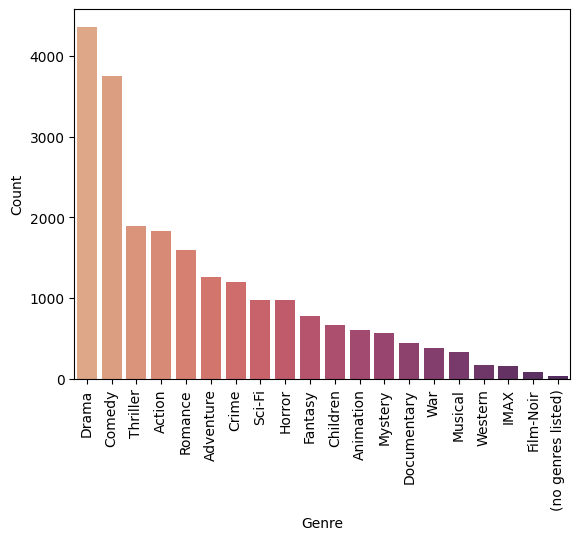

In [78]:
genre_frequency_df =pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['Genre', 'Count']

# genre_frequency_df.head()
sns.barplot(x='Genre', y ='Count', data = genre_frequency_df.sort_values(by='Count',ascending=False),palette='flare')
plt.xticks(rotation=90)

### Step 4: Data Pre-processing

collab filtering & utility matrix.


In [82]:
from scipy.sparse import csr_matrix

def create_X(df):

    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [83]:
X.shape

(610, 9724)

In [85]:
# user_mapper

Our `X` matrix contains 610 users and 9724 movies.

In [87]:
n_total =X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


`csr_matrix.nnz` counts the stored values in our sparse matrix. The rest of our cells are empty.

The **cold start problem** is when there are new users and movies in our matrix that do not have any ratings. In our Movielens dataset, all users and movies have at least one rating but in general, it's useful to check which users and movies have few interactions.

In [88]:
n_ratings_per_user =X.getnnz(axis=1)
len(n_ratings_per_user)

610

In [89]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2698 movies.
Least active user rated 20 movies.


In [90]:
n_ratings_per_movie =X.getnnz(axis=0)
len(n_ratings_per_movie)

9724

In [91]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


In [93]:
X

<610x9724 sparse matrix of type '<class 'numpy.float64'>'
	with 100836 stored elements in Compressed Sparse Row format>

<ipython-input-94-44089890dcd7>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_user, shade=True)
<ipython-input-94-44089890dcd7>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_movie, shade=True)


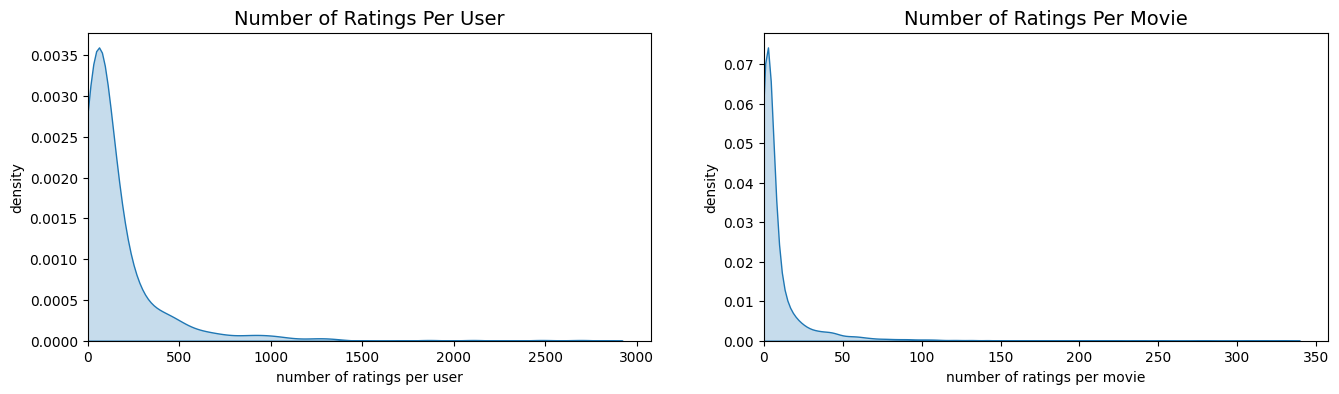

In [94]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

### Step 5: Item-item Recommendations with k-Nearest Neighbors

In [95]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):

    X = X.T
    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [96]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[3114, 480, 780, 260, 356, 364, 1210, 648, 1265]

In [100]:
movie_titles = dict(zip(movies['movieId'], movies['title']))
# movie_titles
movie_id = 3

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
  print(movie_titles[i])


Because you watched Grumpier Old Men (1995):
Grumpy Old Men (1993)
Striptease (1996)
Nutty Professor, The (1996)
Twister (1996)
Father of the Bride Part II (1995)
Broken Arrow (1996)
Bio-Dome (1996)
Truth About Cats & Dogs, The (1996)
Sabrina (1995)


In [101]:
movie_id = 3

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Grumpier Old Men (1995):
Son in Law (1993)
Striptease (1996)
Juror, The (1996)
Flipper (1996)
Beverly Hillbillies, The (1993)
Bio-Dome (1996)
Kazaam (1996)
Angus (1995)
Tales from the Crypt Presents: Bordello of Blood (1996)


 Handling the cold-start problem


In [102]:
n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 9742 unique movies in our movies dataset.


In [107]:
genres = set(g for G in movies['genres'] for g in G)

for g in genres:
    movies[g] =movies.genres.transform(lambda x: int (g in x))

movie_genres = movies.drop(columns=['movieId', 'title','genres'])

In [110]:
# movie_genres

In [ ]:
movie_genres.head()

In [111]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (9742, 9742)


In [113]:
# cosine_sim[0]

In [118]:
# !pip install fuzzywuzzy
from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0]

Let's test this out with our Jumanji example.

In [119]:
title = movie_finder('juminji')
title

'Jumanji (1995)'

In [120]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"Movie index for Jumanji: {idx}")

Movie index for Jumanji: 1


In [124]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
# sim_scores
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
sim_scores


[(53, 1.0000000000000002),
 (109, 1.0000000000000002),
 (767, 1.0000000000000002),
 (1514, 1.0000000000000002),
 (1556, 1.0000000000000002),
 (1617, 1.0000000000000002),
 (1618, 1.0000000000000002),
 (1799, 1.0000000000000002),
 (3574, 1.0000000000000002),
 (6075, 1.0000000000000002)]

In [125]:
similar_movies = [i[0] for i in sim_scores]
similar_movies

[53, 109, 767, 1514, 1556, 1617, 1618, 1799, 3574, 6075]

In [126]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Jumanji (1995):


53                     Indian in the Cupboard, The (1995)
109                     NeverEnding Story III, The (1994)
767                       Escape to Witch Mountain (1975)
1514            Darby O'Gill and the Little People (1959)
1556                                  Return to Oz (1985)
1617                        NeverEnding Story, The (1984)
1618    NeverEnding Story II: The Next Chapter, The (1...
1799                        Santa Claus: The Movie (1985)
3574    Harry Potter and the Sorcerer's Stone (a.k.a. ...
6075    Chronicles of Narnia: The Lion, the Witch and ...
Name: title, dtype: object

In [127]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Because you watched {title}:")
    print(movies['title'].iloc[similar_movies])

In [129]:
get_content_based_recommendations('Jumanjiy', 5)

Because you watched Jumanji (1995):
53             Indian in the Cupboard, The (1995)
109             NeverEnding Story III, The (1994)
767               Escape to Witch Mountain (1975)
1514    Darby O'Gill and the Little People (1959)
1556                          Return to Oz (1985)
Name: title, dtype: object


Dimensionality Reduction with Matrix Factorization





In [130]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components= 20 , n_iter=10 )
Q = svd.fit_transform(X.T)
Q.shape

(9724, 20)

In [132]:
movie_id = 2

similar_movies = find_similar_movies(movie_id,Q.T, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Jumanji (1995):
Lion King, The (1994)
Home Alone (1990)
Aladdin (1992)
Mrs. Doubtfire (1993)
Mask, The (1994)
Beauty and the Beast (1991)
Ace Ventura: When Nature Calls (1995)
Ace Ventura: Pet Detective (1994)
Casper (1995)
